In [4]:
import cv2
import numpy as np

from keras.layers import Dense
%matplotlib inline
import keras
from keras.models import Sequential
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import scipy
import math
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

import PIL
import billiard
from billiard import Pool
from functools import partial
import pytesseract

Using TensorFlow backend.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
def run_preprocessing(frame_location, location="."):
    single_frame_data_dict = {
        "text": "",
        "timestamp_ms": "0"
    }
    
    frame_abs_path = os.path.join(os.path.abspath(location), frame_location)
    frame_no = frame_abs_path.split("/")[-1].split(".")[0]
    img = cv2.imread(frame_abs_path,0)
    
    print("*****", img, frame_abs_path)
    
    thresold_frames = os.path.join(location, 'thresold_frames')
    binarized_frames = os.path.join(location, 'binarized_frames')
    
    if not os.path.exists(thresold_frames):
        os.makedirs(thresold_frames)
    if not os.path.exists(binarized_frames):
        os.makedirs(binarized_frames)
        
    
    #otsu_1 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,2)

    # connected components
    cc  = cv2.connectedComponents(np.uint8(th2))[1]

    # creating imgage for every single label in the connected components
    con_img = {}
    for label in np.unique(cc[cc>0]):
        image = np.zeros(cc.shape)
        indices = np.where(cc==label)
        image[indices] = 1
        con_img[label] = image

    tot1=0
    i=1
    mask = {}
    i=1

    loaded_scaler = joblib.load('./my_scaler_base_2.pkl')
    model = load_model('./my_model_base_2.h5')

    for elem in con_img.keys():
        x,y,w,h = cv2.boundingRect(np.uint8(con_img[elem]))
        #print("****", x, y, w, h)
        imng = img[y:y+h,x:x+w]
        imng =  scipy.misc.imresize(imng,(32,32)).ravel().reshape(1,1024)
        imng = loaded_scaler.transform(imng)
        imng = imng.reshape((1,32,32,1))
        if np.around(model.predict(imng)) == 1.0:
            #print('yuhoo')
            tot1+=con_img[elem]
    #         mask[i]=con_img[elem]
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i+=1


    thresold_frame = Image.fromarray((cc * 255).astype(np.uint8))
    thresold_frame.save(os.path.join(thresold_frames, 'thresold_' + str(frame_no) + ".jpg"))
    
    binary_frame = Image.fromarray((tot1 * 255).astype(np.uint8))
    binary_frame.save(os.path.join(binarized_frames, 'binary_' + str(frame_no) + ".jpg"))
    
    final_image = cv2.imread(os.path.join(binarized_frames, 'binary_' + str(frame_no) + ".jpg"), 0)
    final_image = cv2.bitwise_not(final_image)
    print(pytesseract.image_to_string(final_image))

    plt.figure(figsize=[20,10])
    plt.subplot(1,3,1)
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.imshow(cc)

    plt.subplot(1,3,3)
    plt.imshow(tot1, 'gray')
    
    return single_frame_data_dict

***** [[100 100 101 ...  92  92  92]
 [106 107 107 ... 103 103 103]
 [109 110 110 ... 101 101 101]
 ...
 [ 53  54  50 ...  87  87  87]
 [ 44  46  46 ...  88  88  88]
 [ 45  44  46 ...  93  93  93]] /home/void/Projects/OCR/Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/2750.jpg
******* Here
******* Here2


/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/void/Projects/OCR/Text-detection-in-natural-scene-images/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Should we men
help our wives
do housework


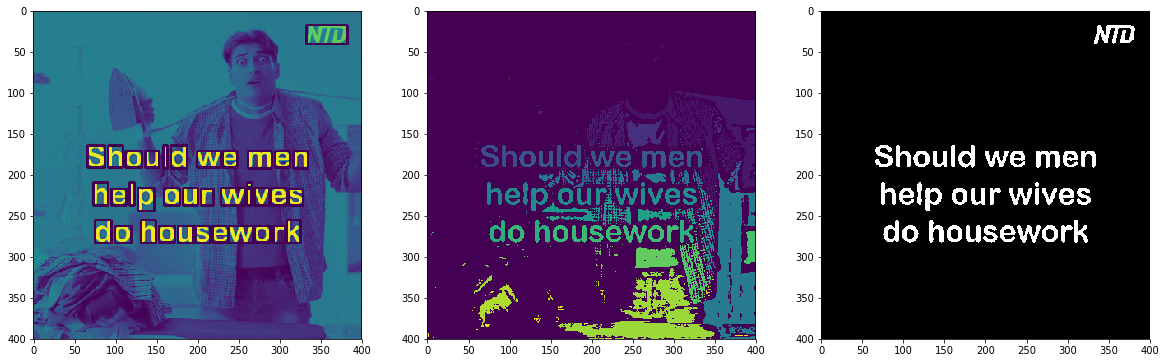

In [11]:
if __name__ == "__main__":
    location = "../Text-detection-in-natural-scene-images-dataset/text or no text dataset/test images/"
    frame = "2750.jpg"
    run_preprocessing(frame_location=frame, location=location)